
# IS-4100: PCA and Clustering with NFL Data

**Objective:**

This lab will introduce you to principal component analysis (PCA) and clustering techniques to analyze and interpret NFL data. You will explore how dimensionality reduction can simplify data and how clustering can reveal patterns within NFL team or player performance metrics.

---

## Section 1: Data Preparation and Exploration

### Load the Data
- Use either `nflfastR` or `nfl_data_py` to load the play-by-play data or season stats for a specific range.
- Filter the data to focus on key columns such as `yards_gained`, `pass_attempt`, `rush_attempt`, `touchdown`, `interception`, `sack`, etc.

### Feature Engineering
- Create aggregated metrics for each team or player, such as:
  - Average yards per game
  - Touchdowns per game
  - Passing and rushing attempts per game
  - Average turnovers per game
- Ensure the final dataset has all numeric columns necessary for PCA and clustering.

### Data Cleaning
- Check for missing values, handling them appropriately.
- Standardize or normalize data to ensure comparability across features.

---

## Section 2: Principal Component Analysis (PCA)

### Perform PCA
- Apply PCA to the dataset to reduce it to two or three principal components.
- Use a scree plot to determine the number of components that capture the majority of variance.

### Interpret PCA Results
- Examine the component loadings to understand which metrics contribute most to each principal component.
- Discuss how PCA has simplified the data and retained the most critical information.

### Visualization
- Plot the data points in a 2D or 3D scatterplot using the principal components as axes.
- Label data points by team or player for better insights.

---

## Section 3: Clustering

### Choosing a Clustering Algorithm
- Select either K-means or hierarchical clustering for this analysis.
- Determine an appropriate number of clusters by using techniques like the elbow method or silhouette score.

### Run Clustering Algorithm
- Apply the chosen clustering algorithm to the PCA-reduced dataset.
- Assign a cluster label to each team or player based on the results.

### Visualize Clusters
- Create a scatter plot showing the clusters with different colors, and label key data points.
- Discuss the composition of each cluster (e.g., are certain teams or players consistently high-performing in specific metrics?).

---

## Section 4: Interpretation and Analysis

### Analyze Cluster Characteristics
- Compare clusters to identify patterns, such as clusters of teams with strong passing vs. rushing stats or players with high-risk, high-reward play styles.

### Discuss Findings
- Write a summary explaining how PCA helped to reduce data complexity and what the clusters reveal about NFL team or player performance.


---

## Questions for Reflection:
1. How did PCA simplify the dataset, and what insights were preserved?
2. Were there any clusters that grouped similar types of players or teams? Describe these patterns.
3. If you were to adjust the clustering parameters, what changes might you explore?

## Setup and Data Retrieval

In [1]:
packages <- c("tidyverse", "nflfastR", "multiUS", "ggthemes", 'gridExtra', 'cluster', 'nflreadr', 'RColorBrewer')
install.packages(packages)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘globals’, ‘listenv’, ‘parallelly’, ‘snakecase’, ‘gtools’, ‘caTools’, ‘fastrmodels’, ‘furrr’, ‘future’, ‘janitor’, ‘progressr’, ‘xgboost’, ‘gplots’




In [ ]:
lapply(packages, library, character.only = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[[1]]
 [1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "nflfastR"  "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"    
 [7] "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "multiUS"   "nflfastR"  "lubridate" "forcats"   "stringr"   "dplyr"    
 [7] "purrr"     "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse"
[13] "stats"     "graphics"  "grDevices" "utils"     "datasets"  "methods"  
[19] "base"     

[[4]]
 [1] "ggthemes"  "multiUS"   "nflfastR"  "lubridate" "forcats"   "stringr"  
 [7] "dplyr"     "purrr"     "readr"     "tidyr"     "tibble"    "ggplot2"  
[13] "tidyverse" "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[19] "methods"   "base"

In [ ]:
seasons <- c(2018:2024)
pbp <- load_pbp(seasons)
schedules <- load_schedules(seasons)

## Data Prep

In [ ]:
# Filter only pass data
pass <- pbp |>
  filter(play_type == 'pass')

# Filter only run data
run <- pbp |>
  filter(play_type == 'run')


In [ ]:
# Create Aggregate Stats for passing data
pass_stats <- pass |>
  group_by(season, posteam) |>
  summarise(
    Passing_Yards = sum(yards_gained),
    Interceptions = sum(interception),
    Passing_Touchdowns = sum(touchdown),
    .groups = 'drop'
  )

# Create Aggregate Stats for rushing data
rush_stats <- run |>
  group_by(season, posteam) |>
  summarise(
    Rushing_Yards = sum(yards_gained),
    Rushing_Touchdowns = sum(touchdown),
    .groups = 'drop'
  )


In [ ]:
Offensive_Stats <- pass_stats |>
  inner_join(rush_stats, by = c("season", "posteam")) |>
  mutate(
    Season = season,
    Team = posteam
  )

In [ ]:
# Set variable to grab teams
seasons <- unique(schedules$season)
teams <- unique(schedules$home_team)
records <- list()  # Initialize an empty list to store rows efficiently

# This for loop goes through the data frame to get season averages for each team
for (team in teams) {
  currentTeam <- schedules %>%
    filter(home_team == team | away_team == team)

  for (s in seasons) {
    currentSeason <- currentTeam %>%
      filter(season == s)

    # Calculate wins, losses, points allowed, and points scored
    stats <- currentSeason %>%
      summarise(
        Wins = sum((home_team == team & home_score > away_score) | (away_team == team & away_score > home_score), na.rm = TRUE),
        Losses = sum((home_team == team & home_score < away_score) | (away_team == team & away_score < home_score), na.rm = TRUE),
        Points_Scored = sum(case_when(home_team == team ~ home_score, away_team == team ~ away_score), na.rm = TRUE),
        Points_Allowed = sum(case_when(home_team == team ~ away_score, away_team == team ~ home_score), na.rm = TRUE),
        Games_Played = Wins + Losses  # Count total games played by the team
      )

    # Only calculate averages if games were played
    if (stats$Games_Played > 0) {
      ppg <- stats$Points_Scored / stats$Games_Played
      pa <- stats$Points_Allowed / stats$Games_Played
      wp <- stats$Wins / stats$Games_Played
      diff <- (stats$Points_Scored - stats$Points_Allowed) / stats$Games_Played
    } else {
      ppg <- 0
      pa <- 0
      wp <- 0
      diff <- 0
    }

    newRow <- data.frame(Team = team, Season = s, Wins = stats$Wins, Losses = stats$Losses,
                         Avg_Points_Scored = ppg, Avg_Points_Allowed = pa,
                         Avg_Point_Differential = diff, Win_Percentage = wp)

    records[[length(records) + 1]] <- newRow  # Store the new row in the list
  }
}

# Combine all rows into a data frame
records_df <- do.call(rbind, records)

In [ ]:
Offensive_Stats <- Offensive_Stats |>
  inner_join(records_df, by = c("Season", "Team"))

In [ ]:
# Clean the data frame
Offensive_Stats <- Offensive_Stats |>
  # Create per game metrics instead of season totals
  mutate(
    Pass_TD = Passing_Touchdowns / (Wins + Losses),
    Pass_Yds = Passing_Yards / (Wins + Losses),
    Ints = Interceptions / (Wins + Losses),
    Rush_TD = Rushing_Touchdowns  / (Wins + Losses),
    Rush_Yds = Rushing_Yards / (Wins + Losses)
  ) |>
  select(-Passing_Touchdowns, -Passing_Yards, -Interceptions, -Rushing_Touchdowns, -Rushing_Yards, -season, -posteam, -Wins, -Losses) |>
  filter(Pass_TD != Inf)

In [ ]:
head(Offensive_Stats)

Season,Team,Avg_Points_Scored,Avg_Points_Allowed,Avg_Point_Differential,Win_Percentage,Pass_TD,Pass_Yds,Ints,Rush_TD,Rush_Yds
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018,ARI,14.06250,26.56250,-12.500000,0.1875000,1.187500,157.8125,1.1250000,0.5625000,84.5000
2018,ATL,25.87500,26.43750,-0.562500,0.4375000,2.437500,291.0625,0.4375000,0.6875000,98.7500
2018,BAL,23.88235,18.23529,5.647059,0.5882353,1.235294,217.5294,0.5882353,1.1176471,150.2941
2018,BUF,16.81250,23.37500,-6.562500,0.3750000,1.187500,172.8750,1.4375000,0.9375000,124.5625
2018,CAR,23.50000,23.87500,-0.375000,0.4375000,1.812500,240.0000,1.0000000,1.0625000,134.5000
2018,CHI,25.64706,17.58824,8.058824,0.7058824,1.764706,227.2353,0.8235294,0.9411765,118.8824


In [ ]:
# Scale all numeric predictors
scaled_stats <- Offensive_Stats |>
  select(-Season, -Team) |>
  scale()

## PCA

In [ ]:
pca_df <- prcomp(scaled_stats)

In [ ]:
pca_df$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Avg_Points_Scored,0.4381762,0.20953336,-0.19364779,-0.0427396312,0.02936199,-0.07202553,0.12265281,0.65556180,-5.233703e-01
Avg_Points_Allowed,-0.2471461,0.37705511,-0.55356124,-0.3400218683,-0.02232067,-0.34248417,-0.17914551,0.19933914,4.302098e-01
Avg_Point_Differential,0.4563424,-0.07144420,0.18598583,0.1684666223,0.03394804,0.14906826,0.19205630,0.34987590,7.355291e-01
Win_Percentage,0.4295155,-0.05268412,0.20493506,0.1441327696,-0.05107779,-0.68834675,-0.49035296,-0.18191206,-1.318390e-16
Pass_TD,0.2907491,0.48650578,-0.01396851,-0.0886067616,0.52725751,-0.08393503,0.40733825,-0.46878649,-9.020562e-17
Pass_Yds,0.2464141,0.54864356,0.04245800,0.0004600813,-0.35268647,0.52232239,-0.45924456,-0.16838475,-1.387779e-16
Ints,-0.2257541,0.23750297,-0.23952187,0.9041449272,0.10816485,-0.05014144,-0.01942948,0.05645675,2.775558e-17
Rush_TD,0.3157021,-0.21634603,-0.52839775,0.0892522577,-0.56332617,-0.05094660,0.36156118,-0.34014409,-1.318390e-16
Rush_Yds,0.2414556,-0.40636735,-0.49082448,-0.0103831659,0.51327771,0.31064262,-0.40938675,-0.08943115,-9.020562e-17




*  **PC1**: The predictors most important to this component are Average Points Scored, Average Point Differential, and Win_Percentage.
*  **PC2**: The predictors most important to this principal component are Average Point Allowed and Passing Yards per game.




In [ ]:
# View Percent of Variance contained in each PC
pca_var <-
  pca_df$sdev^2

pca_percent <-
  round(
    pca_var / sum(pca_var) * 100,
    2
  )

pca_percent

[1] 48.82 22.11 12.19  8.09  4.62  2.03  1.53  0.60  0.00

First three PC contain about 80% of the variance.

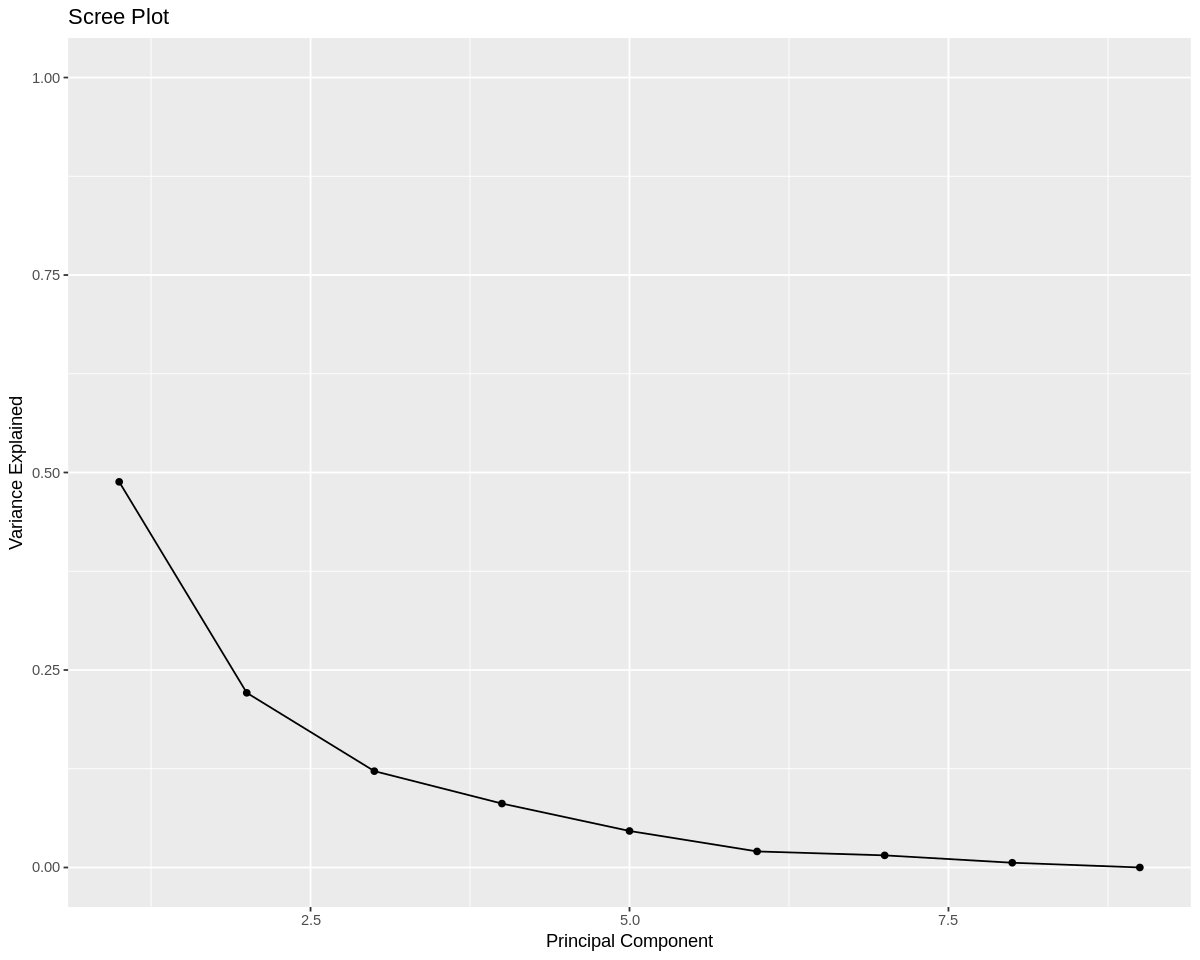

In [ ]:
# Scree Plot
var_explained <- pca_df$sdev^2 / sum(pca_df$sdev^2)

qplot(c(1:length(var_explained)), var_explained) +
  geom_line() +
  xlab("Principal Component") +
  ylab("Variance Explained") +
  ggtitle("Scree Plot") +
  ylim(0, 1)

In [ ]:
# Combine PCs to orignal dataset
Offensive_Stats <-
  Offensive_Stats |>
    bind_cols(pca_df$x)

In [ ]:
Offensive_Stats <- Offensive_Stats |>
  select(-PC4, -PC5, -PC6, -PC7, -PC8, -PC9)

In [ ]:
head(Offensive_Stats)

Season,Team,Avg_Points_Scored,Avg_Points_Allowed,Avg_Point_Differential,Win_Percentage,Pass_TD,Pass_Yds,Ints,Rush_TD,Rush_Yds,PC1,PC2,PC3,PC4
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018,ARI,14.06250,26.56250,-12.500000,0.1875000,1.187500,157.8125,1.1250000,0.5625000,84.5000,-4.6012495,-0.2179181,0.08183126,0.2658666
2018,ATL,25.87500,26.43750,-0.562500,0.4375000,2.437500,291.0625,0.4375000,0.6875000,98.7500,0.7127288,2.5947245,0.42479791,-1.8115242
2018,BAL,23.88235,18.23529,5.647059,0.5882353,1.235294,217.5294,0.5882353,1.1176471,150.2941,1.5021357,-2.0399289,0.15322503,0.1328355
2018,BUF,16.81250,23.37500,-6.562500,0.3750000,1.187500,172.8750,1.4375000,0.9375000,124.5625,-2.5446027,-1.0333483,-0.90013332,1.9927375
2018,CAR,23.50000,23.87500,-0.375000,0.4375000,1.812500,240.0000,1.0000000,1.0625000,134.5000,0.1964568,0.3203734,-0.99760469,0.5508970
2018,CHI,25.64706,17.58824,8.058824,0.7058824,1.764706,227.2353,0.8235294,0.9411765,118.8824,1.8827868,-0.4699604,1.15817706,0.9897619


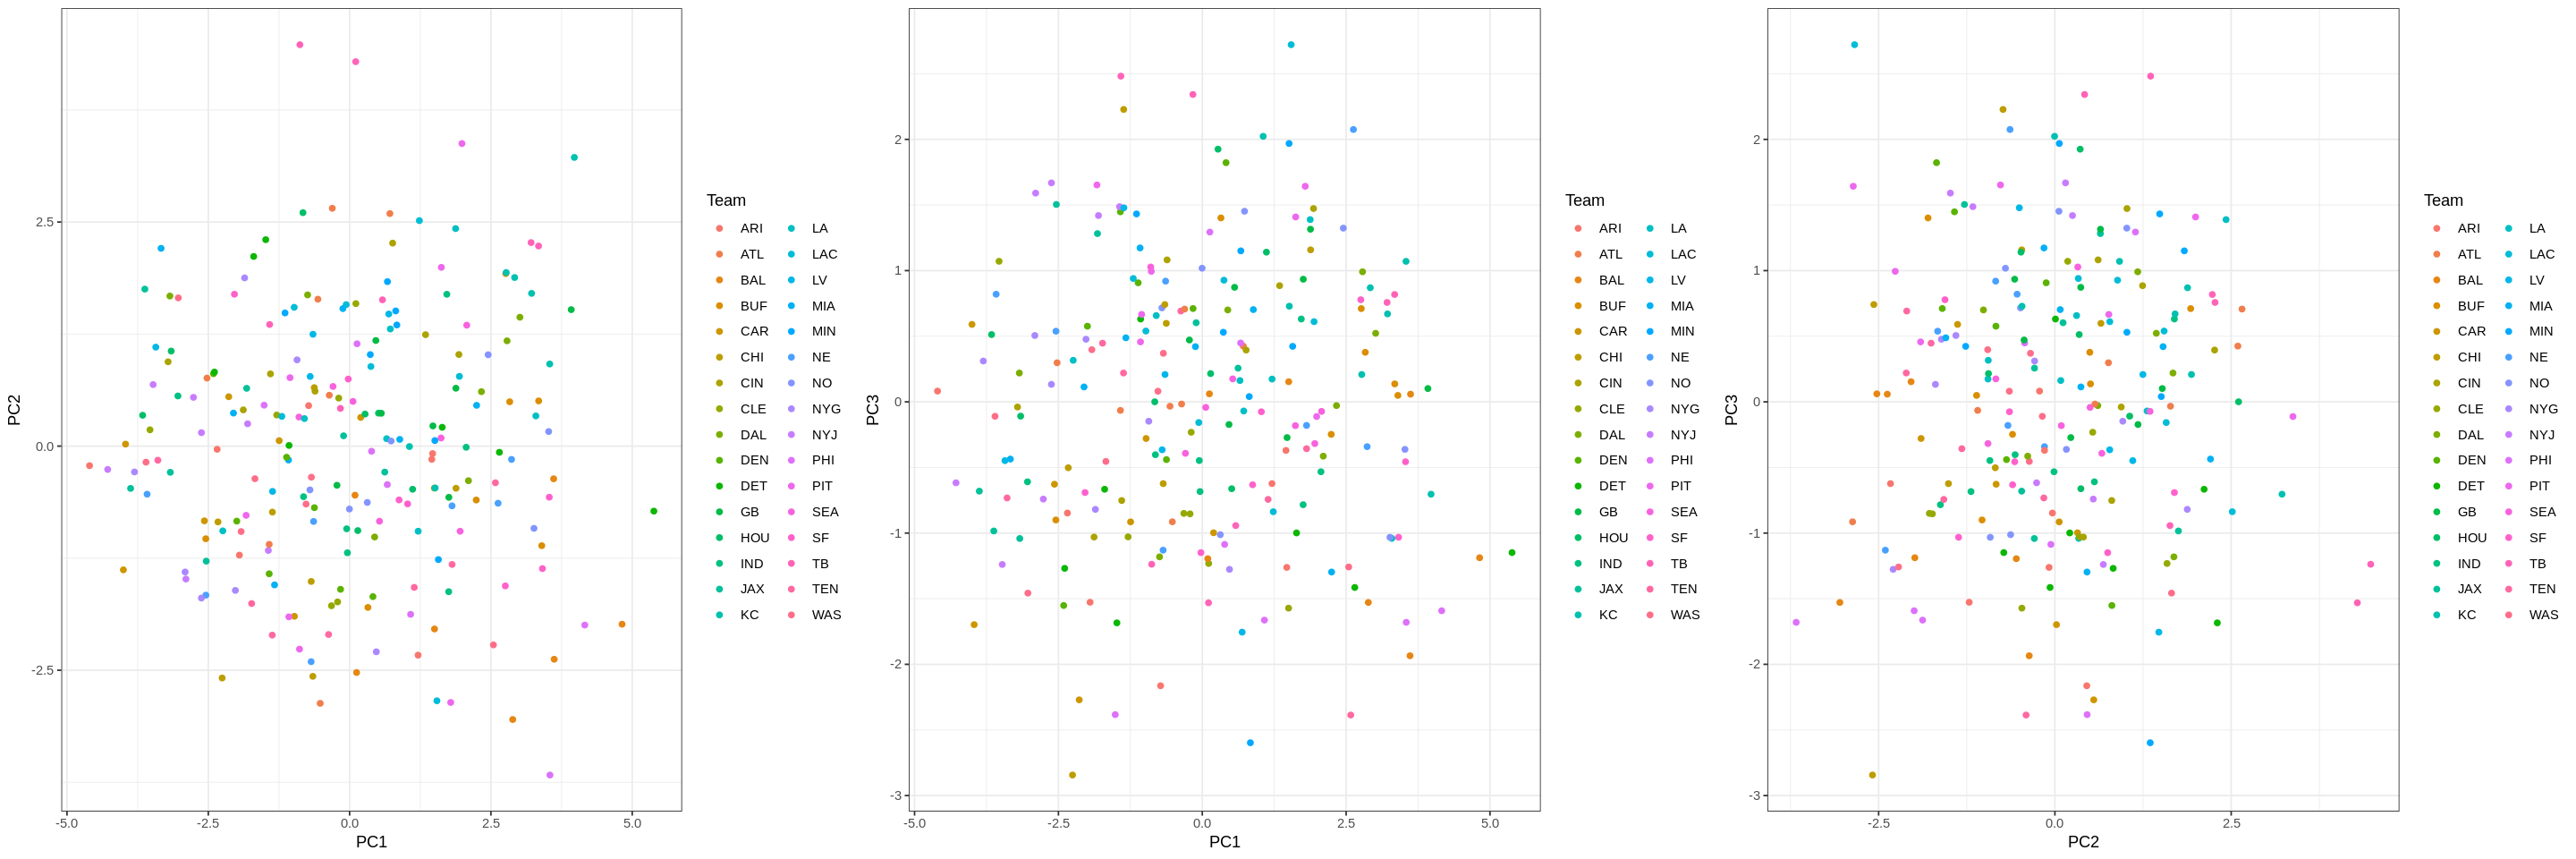

In [ ]:
# Plot the PCs
options(repr.plot.width = 24, repr.plot.height = 8)

p1 <- Offensive_Stats |>
  ggplot(aes(PC1, PC2, color = Win_Percentage)) +
    geom_point() +
    theme_bw()


p2 <- Offensive_Stats |>
  ggplot(aes(PC1, PC3, color = Team)) +
    geom_point() +
    theme_bw()


p3 <- Offensive_Stats |>
  ggplot(aes(PC2, PC3, color = Team)) +
    geom_point() +
    theme_bw()

grid.arrange(p1, p2, p3, ncol = 3)

No apparent correlation, PCA has worked.

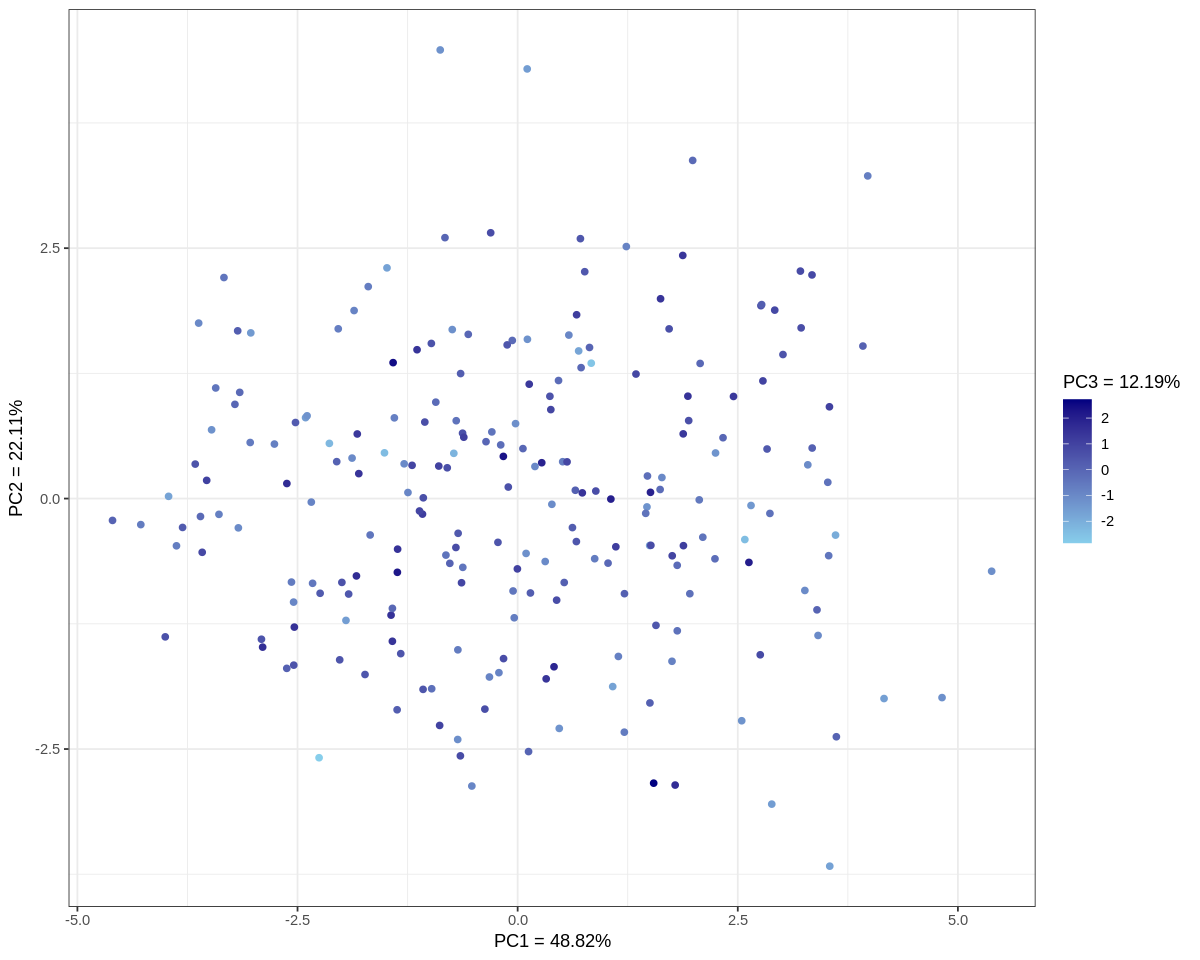

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(Offensive_Stats, aes(PC1, PC2, color = PC3)) +
  geom_point() +
  theme_bw() +
  xlab(paste0(
    'PC1 = ', pca_percent[1], '%'
  )) +
  ylab(paste0(
    'PC2 = ', pca_percent[2], '%'
  )) +
  scale_color_continuous(paste0('PC3 = ', pca_percent[3], "%"),
                         low = 'skyblue',
                         high = 'navyblue')

## Clustering

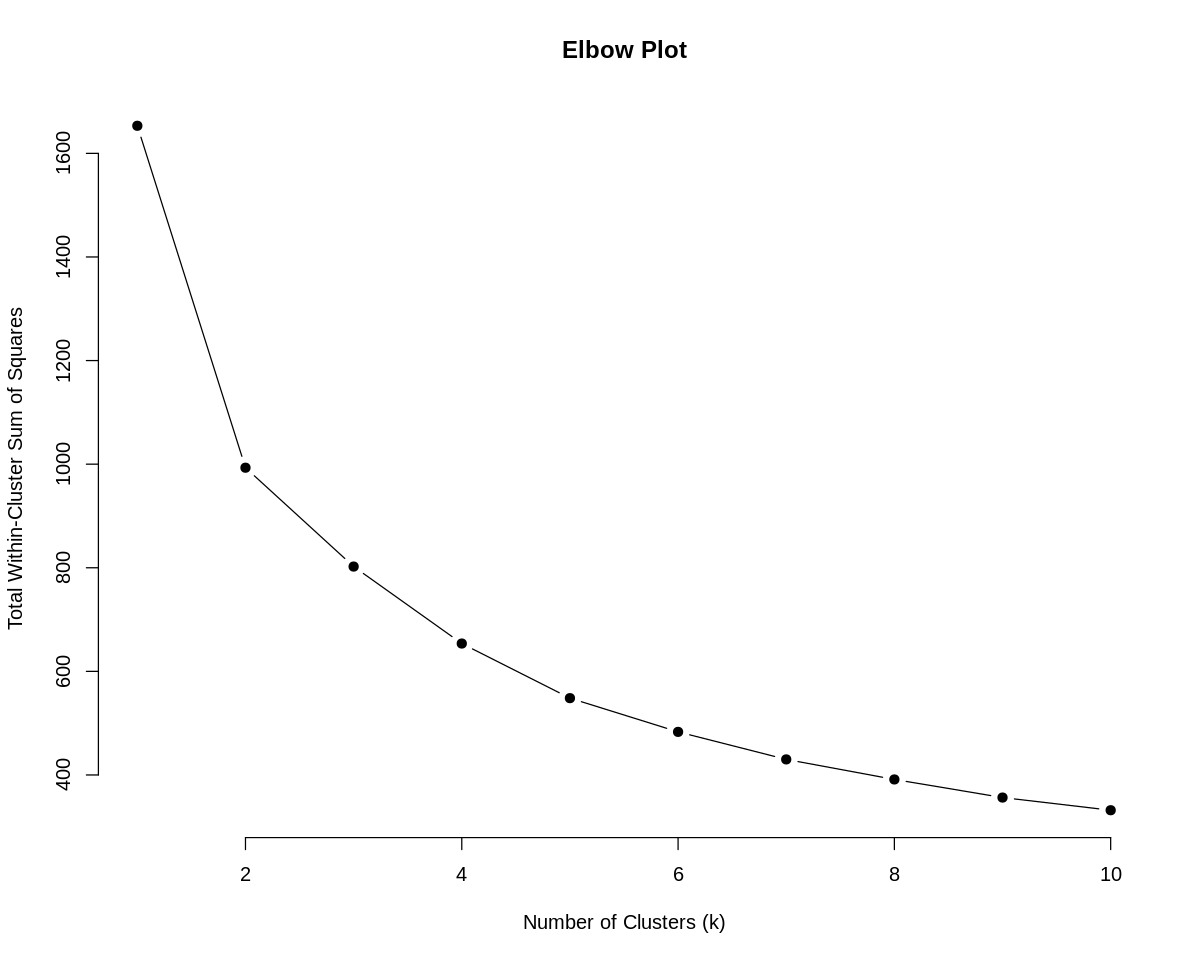

In [ ]:
set.seed(707)

df <- Offensive_Stats |>
  select(PC1, PC2, PC3)

wss <- function(k) {
  kmeans(df, centers = k, nstart = 25)$tot.withinss
}

# Range of k (number of clusters) to evaluate
k_values <- 1:10

# Compute WSS for each k
wss_values <- sapply(k_values, wss)

# Create Elbow Plot
plot(k_values, wss_values, type = "b",
     xlab = "Number of Clusters (k)",
     ylab = "Total Within-Cluster Sum of Squares",
     main = "Elbow Plot",
     pch = 19, frame = FALSE)

Elbow Point is at about 5 or 6.

In [ ]:
# Silhouette Score to decide number of clusters


In [ ]:
# Run K means with optimal number of clusters
k_means_fit <- kmeans(df, 6)


# Add clusters to df
Offensive_Stats <-
  Offensive_Stats |>
    mutate(
      cluster = k_means_fit$cluster
    )

In [ ]:
Offensive_Stats |>
  select(Season, Team, Avg_Points_Scored:Rush_Yds, cluster) |>
  head()

Season,Team,Avg_Points_Scored,Avg_Points_Allowed,Avg_Point_Differential,Win_Percentage,Pass_TD,Pass_Yds,Ints,Rush_TD,Rush_Yds,cluster
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2018,ARI,14.06250,26.56250,-12.500000,0.1875000,1.187500,157.8125,1.1250000,0.5625000,84.5000,4
2018,ATL,25.87500,26.43750,-0.562500,0.4375000,2.437500,291.0625,0.4375000,0.6875000,98.7500,1
2018,BAL,23.88235,18.23529,5.647059,0.5882353,1.235294,217.5294,0.5882353,1.1176471,150.2941,2
2018,BUF,16.81250,23.37500,-6.562500,0.3750000,1.187500,172.8750,1.4375000,0.9375000,124.5625,4
2018,CAR,23.50000,23.87500,-0.375000,0.4375000,1.812500,240.0000,1.0000000,1.0625000,134.5000,1
2018,CHI,25.64706,17.58824,8.058824,0.7058824,1.764706,227.2353,0.8235294,0.9411765,118.8824,2


In [ ]:
Offensive_Stats_Cluster <- Offensive_Stats |>
  group_by(cluster) |>
  summarize(
    Count = n(),
    PPG = mean(Avg_Points_Scored),
    PA = mean(Avg_Points_Allowed),
    Differential = mean(Avg_Point_Differential),
    Win_Percentage = mean(Win_Percentage),
    Pass_Yds = mean(Pass_Yds),
    Rush_Yds = mean(Rush_Yds),
    Pass_TD = mean(Pass_TD),
    Rush_TD = mean(Rush_TD),
    Int = mean(Ints)
  )

Offensive_Stats_Cluster

cluster,Count,PPG,PA,Differential,Win_Percentage,Pass_Yds,Rush_Yds,Pass_TD,Rush_TD,Int
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41,24.01802,25.85564,-1.837619,0.4382221,259.0759,106.8168,1.899253,0.8630078,0.8697863
2,50,23.84810,21.06829,2.779801,0.5816241,219.5471,132.8882,1.519215,1.0879445,0.6598210
3,19,28.94510,20.53536,8.409738,0.7390477,234.1526,152.3911,1.780284,1.5891732,0.5825204
4,39,18.36226,27.00979,-8.647533,0.2509415,202.1270,106.9888,1.304921,0.7296449,1.0603791
5,26,28.36765,21.15621,7.211450,0.7175495,273.0380,112.2702,2.343355,0.9349152,0.7117643
6,47,19.13516,21.39389,-2.258737,0.4286320,205.0486,108.3498,1.254080,0.7348864,0.7605099


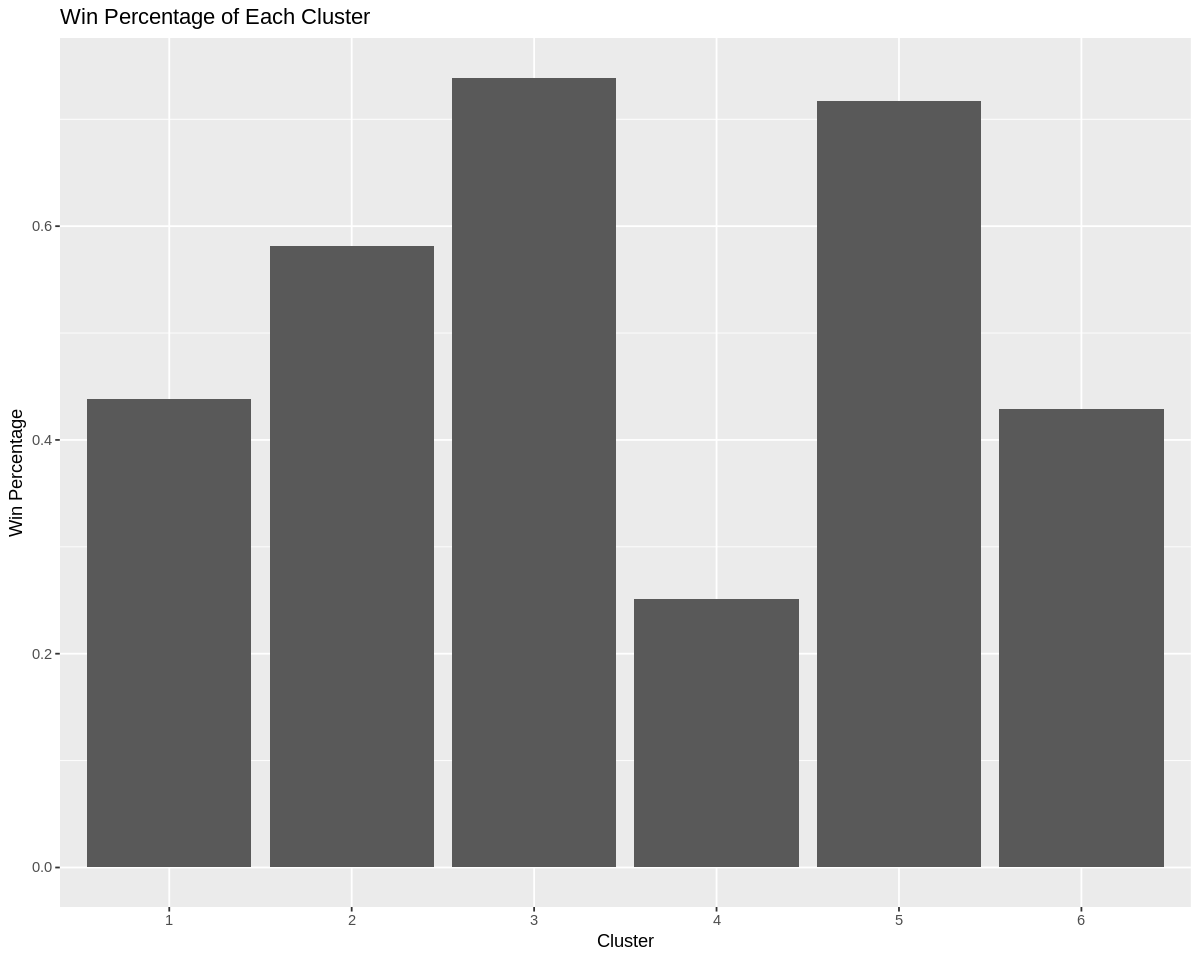

In [ ]:
Offensive_Stats_Cluster |>
  ggplot(aes(factor(cluster), Win_Percentage)) +
    geom_bar(stat = 'identity') +
    xlab("Cluster") +
    ylab("Win Percentage") +
    labs(title = "Win Percentage of Each Cluster")

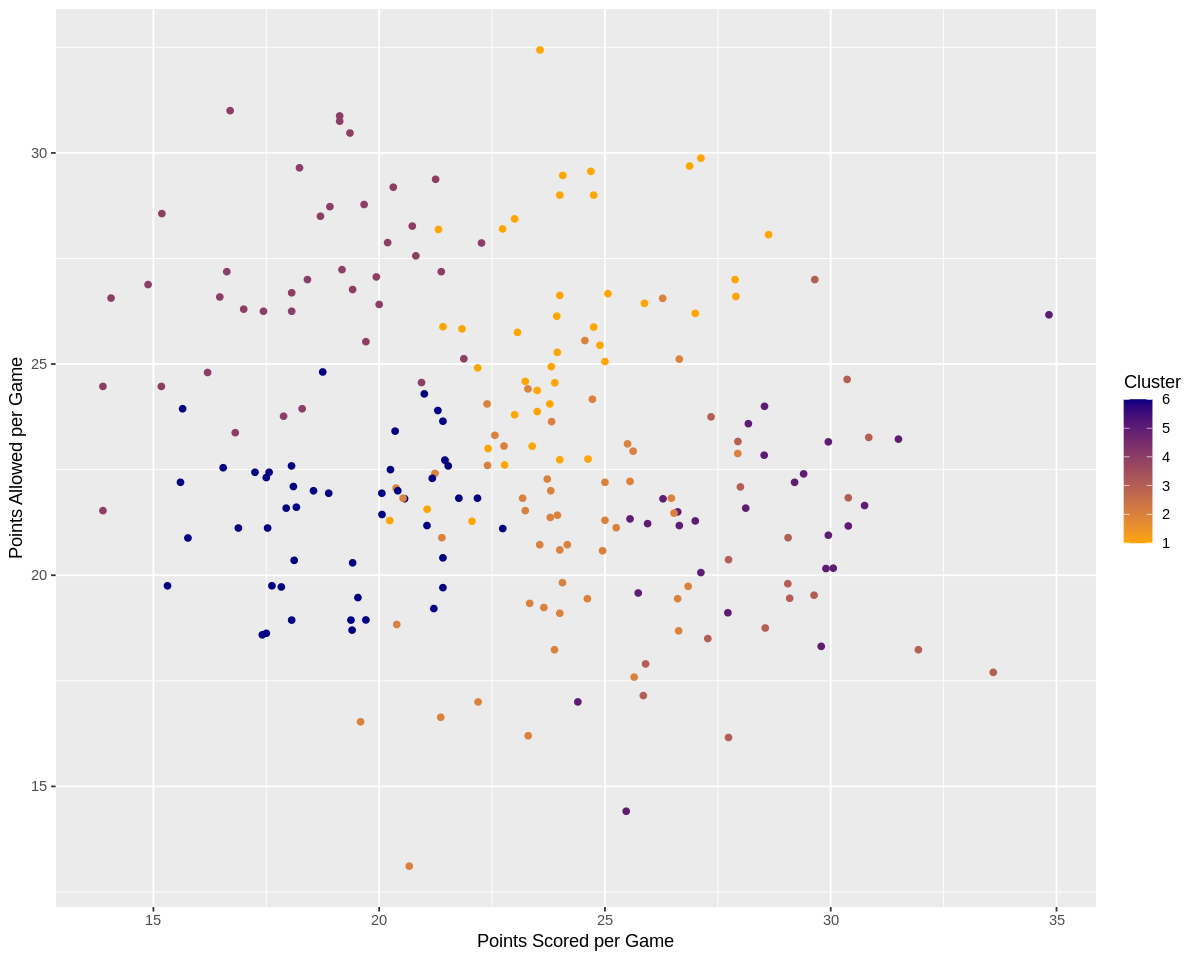

In [ ]:
Offensive_Stats |>
  ggplot(aes(Avg_Points_Scored, Avg_Points_Allowed, color = cluster)) +
    geom_point() +
    scale_color_continuous('Cluster',
                         low = 'orange',
                         high = 'navyblue') +
    xlab('Points Scored per Game') +
    ylab('Points Allowed per Game')

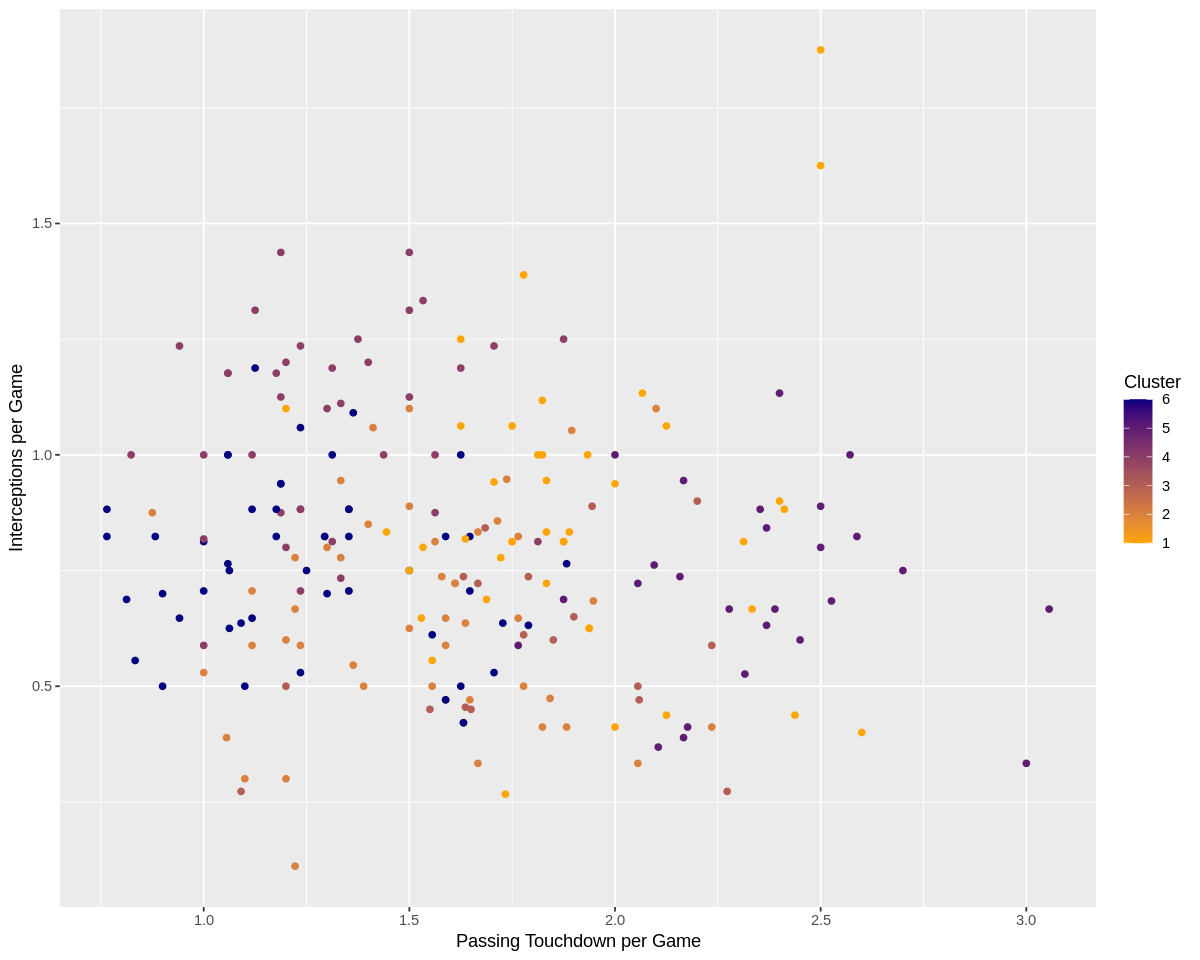

In [ ]:
Offensive_Stats |>
  ggplot(aes(Pass_TD, Ints, color = cluster)) +
    geom_point() +
    scale_color_continuous('Cluster',
                         low = 'orange',
                         high = 'navyblue') +
    xlab('Passing Touchdown per Game') +
    ylab('Interceptions per Game')

## Analysis

Using our clusters let's take a look at the recent SuperBowl Champs:

*   **2018**: New England Patriots, Cluster 3
*   **2019**: Kansas City Chiefs, Cluster 5
*   **2020**: Tamba Bay Buccaneers, Cluster 5
* **2021**: Los Angeles Rams, Cluster 5
* **2022**: Kansas City Chiefs, Cluster 5
* **2023**: Kansas City Chiefs, Cluster 1
<br><br>

<p align = 'justify'>As we observe, 4 of the last 6 superbowl winners were in cluster 5. A cluster 3 team won a superbowl and a cluster 1 team also won.
Using this information, we can see which teams from the 2024 season are similar to past Superbowl champs. </p>
<br>

**Cluster 5 Team**:
* Minnesota Vikings

**Cluster 1 Teams**:
* Cincinati Bengals
* Atlanta Falcons

**Cluster 3 Teams**:
* Baltimore Ravens
* Buffalo Bills
* Detroit Lions
* Philadelphia Eagles
* Washington Commanders
<br><br>

<p align = 'justify'>So, Cluster 5 is obviously the most desirable cluster to be in. On the opposite side of the spectrum is Cluster 4. These teams have an abismal 0.259 win percentage and lose their games by an average of a touchdown.</p>
<br>


**Cluster 4 teams in 2024**:
*   Carolina Panthers
*   Cleveland Browns
* Dallas Cowboys
* Jacksonville Jaguars
* Las Vegas Raiders
* Tennessee Titans





In [ ]:
options(width = 200)

Offensive_Stats |>
  filter(Season == 2024) |>
  select(-PC1, -PC2, -PC3, -PC4) |>
  arrange(cluster) |>
  print(n = Inf)

# A tibble: 32 × 12
   Season Team  Avg_Points_Scored Avg_Points_Allowed Avg_Point_Differential Win_Percentage Pass_TD Pass_Yds  Ints Rush_TD Rush_Yds cluster
    <int> <chr>             <dbl>              <dbl>                  <dbl>          <dbl>   <dbl>    <dbl> <dbl>   <dbl>    <dbl>   <int>
 1   2024 ATL                22.2               24.9                 -2.73           0.545    1.64     244. 0.818   0.727    120.        1
 2   2024 CIN                27                 26.2                  0.8            0.4      2.6      255. 0.4     0.8       90.7       1
 3   2024 SEA                23                 23.8                 -0.8            0.5      1.2      261. 1.1     1.3       92.4       1
 4   2024 TB                 27.9               26.6                  1.3            0.4      2.4      236. 0.9     0.8      126         1
 5   2024 ARI                23.8               22                    1.8            0.6      1.2      197  0.3     1.3      151.        2
 6   20